# We're going to tidy up our sumimage with flags

1) Look at the difference image 

2) Mask large outliers

3) Repeat for N iterations

4) Report on changes

**Risks**:
    Ignoring certain stars, although on average this should be fine

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.gridspec as gridspec
from matplotlib import animation
import h5py
from tqdm import tqdm
from sklearn.cluster import DBSCAN
from IPython.display import HTML
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy import stats
from statsmodels import robust

sns.set_palette('colorblind',10)
sns.set_context('notebook')
matplotlib.rc('xtick', labelsize=10) 
matplotlib.rc('ytick', labelsize=10)
matplotlib.rc('axes',labelsize=10) 
locs = ['sector001_camera1_ccd1', 'sector001_camera1_ccd2', 'sector001_camera1_ccd4','sector001_camera3_ccd1']
loc = locs[1]
ddir = '/Users/Oliver/PhD/TASOC/TESS_data/'+loc+'.hdf5'
title = 'TESS '+loc.replace('_',' ')
title

'TESS sector001 camera1 ccd2'

In [2]:
f = h5py.File(ddir, 'r', libver='latest')
indices = np.array(list(f['backgrounds']))[::5]
len(indices)

257

## Lets look at the sumimage

In [5]:
def get_bkg(idx):
    return np.array(f['backgrounds'][idx])

def get_logbkg(idx):
    return np.log10(get_bkg(idx) + np.abs(np.nanmin(get_bkg(idx))) + 1)

def get_image(idx):
    return np.array(f['backgrounds'][idx]) + np.array(f['images'][idx])

def get_logimage(idx):
    return np.log10(get_image(idx) + np.abs(np.nanmin(get_image(idx))) + 1)

def get_corr(idx):
    return np.array(f['images'][idx])

def get_logcorr(idx):
    return np.log10(get_corr(idx) + np.abs(np.nanmin(get_corr(idx))) + 1)

def get_sumimage():
    return np.array(f['sumimage'])

def get_logsumimage():
    return np.log10(get_sumimage() + np.abs(np.nanmin(get_sumimage())) + 1)

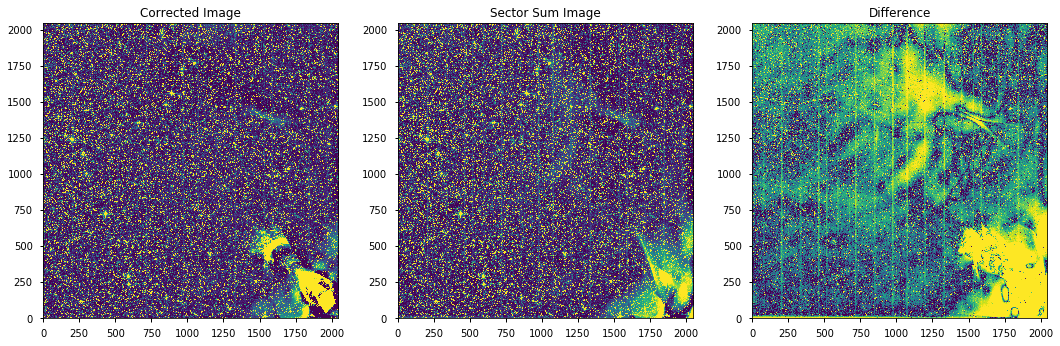

In [6]:
fig, ax = plt.subplots(1,3, figsize=(18,6))
diffimage = np.abs(get_corr('0000') - get_sumimage())
logdiffimage = np.log10(diffimage)

ax[0].imshow(get_logcorr('0000'), origin='lower',
                 vmin = np.nanpercentile(get_logcorr('0000'),[10]), vmax = np.nanpercentile(get_logcorr('0000'), [90]))
ax[1].imshow(get_logsumimage(), origin='lower',
                 vmin = np.nanpercentile(get_logsumimage(),[10]), vmax = np.nanpercentile(get_logsumimage(), [90]))
ax[2].imshow(logdiffimage, origin='lower',
                 vmin = np.nanpercentile(logdiffimage,[10]), vmax = np.nanpercentile(logdiffimage, [90]))
ax[0].set_title('Corrected Image')
ax[1].set_title('Sector Sum Image')
ax[2].set_title('Difference')
plt.show()


### Now lets mask the top 5th percentile and recalculate the sumimage
We calculate the sumimage by stacking all images and dividing by the the average

In [7]:
def percentilemask(diffim, percentile=95):
    return (diffim > np.nanpercentile(diffim,[percentile]))
def madmodemask(diffim, madfraction=1.):
    per = diffim < np.nanpercentile(diffim, [90])
    nan = np.isfinite(diffim[per])

    kde = stats.gaussian_kde(diffim[per][nan], bw_method='scott')
    alpha = np.linspace(np.nanmin(diffim[per]), np.nanmax(diffim[per]), 100)
    mode = alpha[np.argmax(kde(alpha))]
    mad = robust.scale.mad(diffim[per][nan].flatten())
    return (diffim>(mode+mad*madfraction))

In [8]:
def improve_sumimage(sumimage, iters = 5, method='percentile', plots=False):
    # Build a stack of corrimages once
    corrstack = np.empty((len(indices), sumimage.shape[0], sumimage.shape[1]))
    for i, idx in enumerate(indices):
        corrstack[i] = get_corr(idx)
    
    nanmasks = np.ones((len(indices), sumimage.shape[0], sumimage.shape[1]))
    for n in range(iters):
        tower = np.empty((len(indices),sumimage.shape[0], sumimage.shape[1]))
        for i, idx in tqdm(enumerate(indices)):
            #This is actually faster than doing it all in numpy operations, for now
            diffimage = np.abs(corrstack[i] - sumimage)
            if method == 'percentile':
                flagmask = percentilemask(diffimage, percentile=90)
            elif method == 'madmode':
                flagmask = madmodemask(diffimage, madfraction=1.)
            nanmasks[i][flagmask] = np.nan
            tower[i] = corrstack[i]*nanmasks[i]
            
            if plots:
                fig = plt.figure()
                logimage = np.log10(tower[i] + np.abs(np.nanmin(tower[i]))+1)
                plt.imshow(logimage, origin='lower',
                           vmin=np.nanpercentile(logimage,[10]), vmax=np.nanpercentile(logimage,[90]))
                plt.title(idx, fontsize=20)
                plt.show()
                plt.close()
            
        sumimage = np.nanmean(tower, axis=0)
        logsumimage = np.log10(sumimage + np.abs(np.nanmin(sumimage)) + 1)
        fig = plt.figure()
        print('I should be showing a figure!')
        plt.imshow(logsumimage, origin='lower',
                 vmin = np.nanpercentile(logsumimage,[10]), vmax = np.nanpercentile(logsumimage, [90]))
        plt.title('Sumimage '+str(n))
        plt.show()
        plt.close()
    return sumimage

257it [01:21,  3.15it/s]
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: Mean of empty slice


I should be showing a figure!


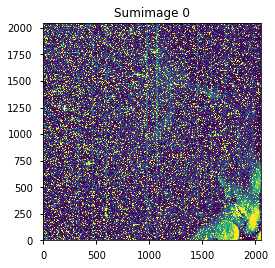

0it [00:00, ?it/s]/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  
10it [00:02,  3.52it/s]

In [ ]:
newsumimage = improve_sumimage(get_sumimage(), iters=5, method='percentile')

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(12,12))

diffimage = np.abs(get_corr('0000') - newsumimage)
logdiffimage = np.log10(diffimage)
lognewsumimage = np.log10(newsumimage + np.abs(np.nanmin(newsumimage)) + 1)

ax[0,0].imshow(get_logsumimage(), origin='lower',
                 vmin = np.nanpercentile(get_logsumimage(),[10]), vmax = np.nanpercentile(get_logsumimage(), [90]))
ax[0,1].imshow(lognewsumimage, origin='lower',
                 vmin = np.nanpercentile(lognewsumimage,[10]), vmax = np.nanpercentile(lognewsumimage, [90]))
ax[1,0].imshow(get_logcorr('0000'), origin='lower',
                 vmin = np.nanpercentile(get_logcorr('0000'),[10]), vmax = np.nanpercentile(get_logcorr('0000'), [90]))
ax[1,1].imshow(logdiffimage, origin='lower',
                 vmin = np.nanpercentile(logdiffimage,[10]), vmax = np.nanpercentile(logdiffimage, [90]))

ax[0,0].set_title('Original Sumimage')
ax[0,1].set_title('New Sumimage')
ax[1,0].set_title('Corrected Image')
ax[1,1].set_title('New Difference Image')
plt.show()